In [12]:
%matplotlib inline
from typing import Tuple,Callable
from numpy import *
import matplotlib.pyplot as plt
import pandas as pd

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [28]:
def finDif(omega:list, f:Callable , n:int, bc:list) -> Tuple[ndarray,ndarray]:
    """
    Function that returns the finite different matrix A and the right hand side b 
    for 4th order finite difference approximation of the second order derivative.
    
    Inputs:
        omega: domain interval.
        f:     forcing function.
        n:     number of discretization points (used inside the domain of the PDE).
        bc:    boundary conditions.
    
    """
    h = (omega[1] - omega[0]) / ( n - 1 )     # choose the step size in the interval omega
    x = linspace(omega[0], omega[1], n)       # define discretization points in the interval omega
    b = f(x)                                  # calculate the function at discretization points
    b[0], b[n-1] = bc                          # set boundary conditions         
    
    A = diag([-1 for i in range(0,n-2)], -2)  \
    + diag([16 for i in range(0,n-1)], -1)    \
    + diag([-30 for i in range(0,n)])         \
    + diag([16 for i in range(0,n-1)], 1)     \
    + diag([-1 for i in range(0,n-2)], 2)     # create the A matrix from the 4th order FD approximation 
    
    A = - A / (12*(h**2))
    
    return A, b

Call the function using:

In [17]:
omega = [0,pi]
f = lambda x : sin(x)
n = 100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [27]:
def LU(A:ndarray, pivot:bool = False):
    """
    Perform LU factorization of the system matrix A.

    Inputs: 
        A: squared and non-singular/invertible matrix.
    
    Notes: The pivot is set by default as False.
           In the case in which the pivot = True, the function returns, not only 
           the lower triangular matrix L and the upper triangular matrix U but also 
           the permutation matrix P.
    """
    
    assert(shape(A)[0] == shape(A)[1]), "The matrix A has to be square"
    assert(linalg.det(A) != 0), "The matrix A has to be invertible/non-singular"
    
    A = array(A, 'float64')                      # convertig to a numpy array
    n = A.shape[0]                               # number of rows/columns
    
    L = eye(n, dtype=double)                     # lower triangular matrix (matrix of multipliers)
    P = eye(n, dtype=double)                     # permutation matrix
    U = A.copy()                                 # upper triangular matrix 
    
    for i in range(n):
        if pivot:
            for k in range(i, n):                # for all the rows below the ith row
                if U[i, i] != 0:                 # select row that has a nonzero value in ith col
                    break
                
                U[[k, k+1]] = U[[k+1, k]]        # exchange rows and columns
                P[[k, k+1]] = P[[k+1, k]]        # exchange rows and columns

        l_factor = U[i+1:, i] / U[i, i]          # define the multiplier l
        L[i+1:, i] = l_factor                    # place the multiplier in matrix L
        U[i+1:] -= l_factor[:,newaxis] * U[i]    # update U matrix at step i
          
    if pivot:
        return P, L, U
    
    return L, U

L, U = LU(A)

In [5]:
def cholesky(A:ndarray) -> Tuple[ndarray,ndarray]:
    """
    Compute cholesky factorization of matrix A.

    Inputs: 
        A: squared, non-singular/invertible and symmetric postive matrix.
   
    Notes: The assumptions for A are checked as first step.
           The function returns the matrix L and its conjugate transpose.
    """
    
    assert(shape(A)[0] == shape(A)[1]), "Matrix has to be squared"
    assert(allclose(A, A.transpose())), "Matrix is not symmetric, Cholesky factorization cannot be computed"
    assert(all(linalg.eigvals(A) > 0)), "Matrix not positive definite, Cholesky factorization cannot be computed "
    
    A = array(A, 'float64')                      # convertig to a numpy array
    n = A.shape[0]                               # number of rows/columns
    L = zeros((n, n), dtype=double)              # initialize matrix L
    
    L[0, 0] = sqrt(A[0, 0])                        # set first element
    
    for i in range(1,n):
        for j in range(i):    
            L[j, i] = (A[i, j] - L[:j, i] @ L[:j, j]) / L[j, j]
        L[i, i] = sqrt(A[i, i] - L[:i, i] @ L[:i, i]) # set diagonal elements
    
    return L, L.transpose()

HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [26]:
def L_solve(L:ndarray, rhs:ndarray) -> ndarray:
    """
    Perform, for a lower triangular matrix L, the forward substitution algorithm
    for solving a system of linear equations.
    
    Inputs: 
        L:   squared and lower triangular matrix.
        rhs: vector.
    
    """  
    assert(shape(L)[0] == shape(L)[1]), "Matrix has to be squared"
    assert(allclose(L, tril(L))), "Matrix is not lower triangular"
    
    L = array(L, dtype = 'float64')           # convertig to a numpy array   
    rhs = array(rhs, dtype = 'float64')       # convertig to a numpy array
    n = L.shape[0]                            # number of rows/columns          
   
    x = zeros_like(rhs, dtype = 'float64')    # allocate space for x: solution vector
    x[0] = rhs[0] / L[0, 0]                   # set x0
    
    for i in range(1, n):
        x[i] = ( rhs[i] - dot(L[i, :i], x[:i] ) ) / L[i, i]
    
    return x

In [25]:
def U_solve(U:ndarray ,rhs:ndarray) -> ndarray:
    """
    Perform, for a upper triangular matrix U, the backward substitution algorithm 
    for solving a system of linear equations.
    
    Inputs: 
        U:   squared and upper triangular matrix.
        rhs: vector of non-linear.
    """ 
    
    assert(shape(U)[0] == shape(U)[1]), "Matrix has to be squared"
    assert(allclose(U, triu(U))), "Matrix is not upper triangular"
    
    U = array(U, dtype = 'float64')          # convertig to a numpy array  
    rhs = array(rhs, dtype = 'float64')      # convertig to a numpy array
    n = U.shape[0]                           # number of rows/columns  
    
    x = zeros_like(rhs, dtype = 'float64')   # allocate space for x: solution vector
    x[-1] = rhs[-1] / U[-1,-1]               # set xn

    for i in range(n-1, -1, -1):
        x[i] = ( rhs[i] - dot(U[i, i+1:], x[i+1:]) ) / U[i, i]   
        
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

In [23]:
def solve_system(A:ndarray ,b:ndarray, pivot:bool = True):
    """
    Function to solve linear system bu LU factorization.
    
    Inouts:
        A: squared and non-singular matrix.
        b: vector of non-linear system.
    
    """
    assert(shape(A)[0] == shape(A)[1]), "Matrix has to be squared"
    assert(linalg.det(A) != 0), "The matrix A has to be invertible/non-singular"
    
    if (pivot):
         P, L, U = LU(A, pivot)   # obtain the factorization
    else:
         L, U = LU(A, pivot)
         P = identity(shape(A)[0]) # if the factorization is performed without pivoting 
                                   # the permutation matrix P is the identity matrix
    
    y = L_solve(L, matmul(b,P))   # find y by exploting the forward substituion algorithm
    x = U_solve(U, y)             # find the solution x by backward substitution algorithm
    return x


In [52]:
def plot_result(omega:int , x:ndarray):
    """
    Function for plotting the solution of a finite difference problem.
    
    Inputs:
        omega: domain interval.
        x:     solved system to be plotted. 
    """
    
    x_points = linspace(omega[0], omega[1], num = shape(x)[0]) #define discretization points

    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(x_points, x)
    plt.xlabel("$\Omega$", fontsize=10)
    plt.title('Solution of FD problem')
    plt.xticks(arange(0, 1.1*pi, step=(pi/4)), ['0','π/4', 'π/2','3π/4','π'])
    plt.tight_layout()   
    return

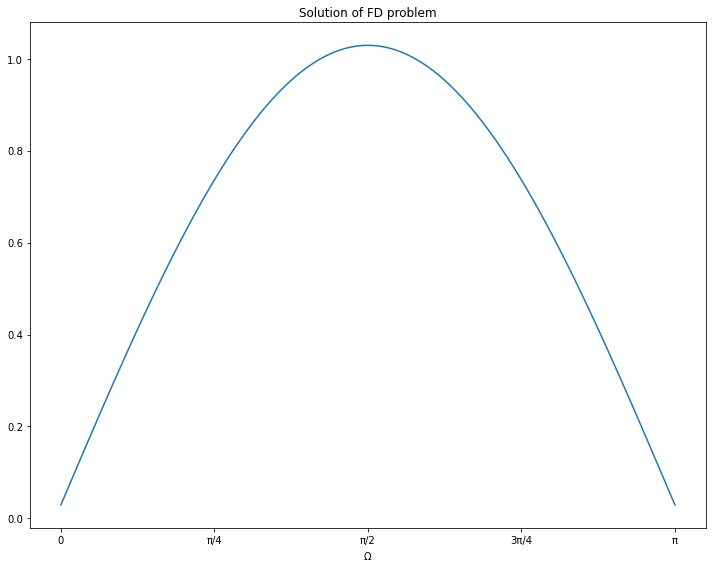

In [53]:
omega = [0,pi]
f = lambda x : sin(x)
n = 100
bc = [0,0]

A, b = finDif(omega, f, n, bc)                  # find matrix A 
solved_system = solve_system(A,b, pivot = True) # solve the system
plot_result(omega, solved_system)               # plot the solution 

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

In [19]:
def error(omega:int, f:Callable, bc:list, f_real:Callable, max_N:int = 400, step:int = 20) -> pd.DataFrame:
    """
    Function for obtaining the error as a function of grid points.
    
    Inputs:
        omega:  domain interval
        f:      forcing function
        bc:     boundary conditions
        f_real: analytical solution for the problem
        max_N:  max number of grid points
        step:   step to which sample grid points
    """
    
    N = arange(20, max_N, step)
    error = zeros(shape(N)[0])
    
    for idx_n, n in enumerate(N):
        A, b = finDif(omega, f, n, bc)                    # find matrix A and b
        solved_system = solve_system(A, b, pivot = True) # solve the system
        x_points = linspace(omega[0], omega[1], num = n)  # define discretization points
        
        error[idx_n] = max(abs(solved_system - f_real(x_points))) # find error at grid points
    
    error_df = pd.DataFrame({'Grid points': N, 'Error': error})
    return error_df

In [54]:
def plot_error(error_df:pd.DataFrame):
    """
    Function to plot the decay of the error with respect to the number of grid points.
    
    Inputs:
        error_df: dataframe of  columns [Iteration, Error]
    """
    
    plt.rcParams["figure.figsize"] = (10,8)
    plt.plot(error_df['Grid points'].values, error_df['Error'].values, label = "${\\Vert \\cdot \\Vert}_{\\infty}$")
    plt.xlabel("Grid points")
    plt.ylabel("Error")
    plt.legend()
    plt.yscale('log')
    plt.title("Decay of the error w.r.t. the number of grid points")
    plt.tight_layout()
    return 

,Grid points,Error
0,20,0.004059
1,40,0.001982
2,60,0.001311
3,80,0.000979
4,100,0.000781
5,120,0.000650
6,140,0.000556
7,160,0.000486
8,180,0.000432
9,200,0.000389


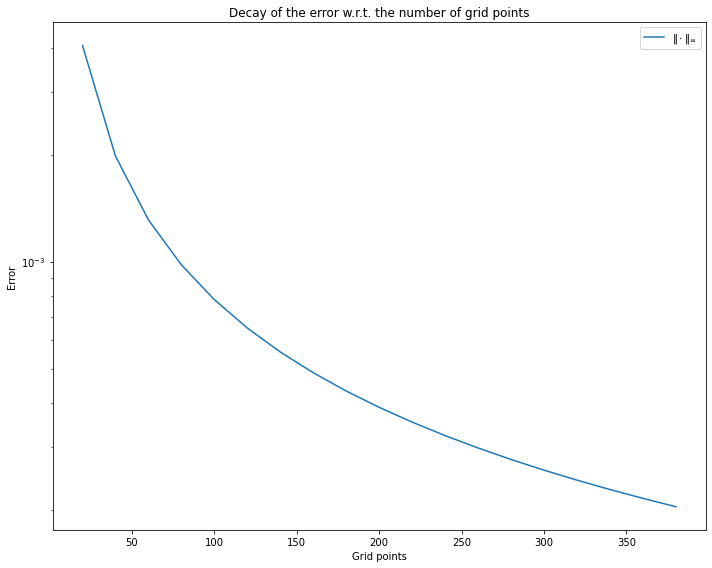

In [50]:
omega = [0,1]
bc = [0,0]
f = lambda x : x*(1-x)
f_real = lambda x: power(x,4) / 12 - power(x,3) / 6 + x / 12
table = error(omega, f, bc, f_real)
plot_error(table)
table

Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [39]:
def power_method(A:ndarray, eps:float = 1e-10, max_iter:int = 1000) -> Tuple[ndarray,ndarray]:
  """
  Given the system matrix A, the function found its maximum eigenvalue by power method.
  Return the evalue l and y.

  Inputs:
    A: squared and non-singular matrix.
    eps: tolerance values.
    max_iter: maximum number of iterations required.
  """
  assert(shape(A)[0] == shape(A)[1]), "Matrix has to be squared"
  assert(linalg.det(A) != 0), "The matrix A has to be invertible/non-singular"

  x = random.rand(shape(A)[0])  #define random x0
  y = x / linalg.norm( x, 2 )   #define y0

  err = eps+1                   #define initial error      
  it = 0                        #counts number of iteratiobs
  l = 0                         #store the value of eigenvalue

  while err > eps and it < max_iter: 
    x_new = A.dot(y)                          #x at iteration k
    y = x_new / linalg.norm( x_new, 2 )       #y at iteration k

    l = y.dot(y.dot(A))                       #eigenvalue

    err = linalg.norm(x_new - l*x,2)          #compute the error
    x = x_new                                 #new value of x 

    it += 1 
    
  return l,y

In [40]:
def inverse_power_method(A:ndarray, mu:float, eps:float = 1e-10, max_iter:int = 1000) -> Tuple[ndarray,ndarray]: 
  """
  Given the system matrix A, the function found the eigenvalue close to number mu by inverse power method .

  Inputs:
    A: squared and non-singular matrix.
    mu: value where to search the eigenvalue.
    eps: tolerance value.
    max_iter: maximum number of iterations requested.
  """
  assert(shape(A)[0] == shape(A)[1]), "Matrix has to be squared"
  assert(linalg.det(A) != 0), "The matrix A has to be invertible/non-singular"

  x0 = random.rand(shape(A)[0])     #define random x0
  y = x0 / linalg.norm( x0, 2 )     #define initial y0

  Amu = A - mu * eye(A.shape[0])    #define Amu
  (L,U) = LU(Amu)                   #find LU factorization of Amu

  err = eps+1                       #define initial error
  it = 0                            #counts number of iterations
  l = 0                             #store the value of eigenvalue

  while err > eps and it < max_iter:
    q = L_solve( L, y )             #solve linear system
    x = U_solve( U, q )             #solve linear in order to find x

    y = x / linalg.norm( x, 2 )     #define new y at iteration k
    z = A.dot(y)                    #new value of x 

    l = y.T.dot(z)                  #find eigenvalue

    err = linalg.norm(z - l*y,2)    #compute the error
    it += 1
    
  return l,y

In [41]:
def condNumb(A:ndarray) -> float:
    """
    Find condition number of matrix A iff A is SPD.

    Input:
        A: squared and symmetric positive matrix.
    """
    assert(shape(A)[0] == shape(A)[1]), "Matrix has to be squared"
    assert(allclose(A, A.transpose())), "Matrix A is not symmetric"
    assert(all(linalg.eigvals(A) > 0)), "Matrix A not positive definite"

    
    l_max = power_method(A)[0]                     # find max evalue by power method
    l_min = inverse_power_method(A, 0.0)[0]        # find min evalue by inverse power method
    condNum = l_max / l_min                        # condNum of SPD matrix is evalue_max/evalue_min
    return condNum
cond_number = condNumb(A)

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [42]:
def conjugate_gradient(A:ndarray, b:ndarray, P:ndarray = None,  eps:float=1e-10) -> ndarray:
    """
    Compute conjugate gradient method on a symmetric positive definite matrix A.
    It returns the solution x of the system.
           
    Inputs: 
        A: squared and SPD matrix.
        b: right hand side of the system.
        P: squared and SPD permutation matrix P, if not given, the identity matrix is used.
        eps: tolerance value.
    """
    
    assert(shape(A)[0] == shape(A)[1]), "Matrix has to be squared"
    assert(allclose(A, A.transpose())), "Matrix A is not symmetric, CG cannot be computed"
    assert(all(linalg.eigvals(A) > 0)), "Matrix A not positive definite, CG cannot be computed"

    if P is None:
        P = identity(shape(A)[0])
    else:
        assert(allclose(P, P.transpose())), "Matrix P is not symmetric, CG cannot be computed"
        assert(all(linalg.eigvals(P) > 0)), "Matrix P not positive definite, CG cannot be computed"

        
    A = array(A, dtype = 'float64')
    b = array(b, dtype = 'float64')
    n = A.shape[0]
    
    x = zeros(n,n)                  #where to store the solution 
    r = b - A.dot(x)                #define the residual
    z = solve_system(P, r)          #solve the linear system in order to find z0
    p = z                           #set p0 equal to z0
  
    for _ in range(1, n):           #for at most n steps 
        if linalg.norm(r) < eps:    #check if end condition is satisfied
            break
            
        alpha = p.dot(r) / A.dot(p).dot(p)          #get the value of alpha
        x += alpha * p                              #update value of x
        r -= alpha * A.dot(p)                       #update value of residual
        z = solve_system(P, r)                      #get zk solving the linear system
        beta = A.dot(p).dot(z) / A.dot(p).dot(p)    #obtain value of beta
        p = z - beta * p                            #update the value of p
        
    return x

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [29]:
def forward_euler(f:Callable, alpha:Callable, omega:list, t0:int, T:int, n:int, bc:list, Nt:int) -> Tuple[ndarray,ndarray,ndarray]:
  """
  Implemet forward Euler method to find solution x for the differential equation.
  Return the solution x. the time t and the discretization points.

  Inputs:
    f: function for which find the solution.
    alpha: time-depend function.
    omega: domain interval
    t0:    lower bound for t
    T:     upper bound for t
    n:     number of discretization points (used inside the domain of the PDE)
    bc:    boundary conditions 
    Nt:    number of nodes for the Forward Euler
  """

  h = ( T - t0 ) / Nt                                         #define time step 
  t = linspace(t0, T, num = Nt+1, dtype='float64')

  u = zeros((n, Nt+1))                                        #initialize space for solution

  A,b = finDif(omega,f,n,bc)                                  #find FD solution 
  x_points = linspace(omega[0], omega[1], num = shape(b)[0])  #define discretization points
  u[:, 0] = solve_system(A, b)                                #solve linear system for get initial solution at t0

  for k in range(Nt):
    u_xx = A.dot(u[:, k])                                     #compute derivative at step before   
    alpha_0 = alpha(t[k])*b                                   #compute function at step before
    u[:,k+1] = u[:, k] - h * u_xx + h * alpha_0

  return u, t, x_points

In [30]:
t0 = 0
T = 6*pi
Nt = 500000

alpha =  lambda t: cos(t)

f = lambda x : sin(x)
omega = [0,pi]
bc = [0,0]
n = 100 

u, t, x = forward_euler(f, alpha, omega, t0, T, n, bc, Nt)

In [32]:
# find right indexes
idx_pi_half = round(n / (omega[-1] - omega[0]) * pi/2) -1
idx_one = round(n/(omega[-1] - omega[0])) - 1
idx_pi = round(n/(omega[-1] - omega[0]) * pi) - 1

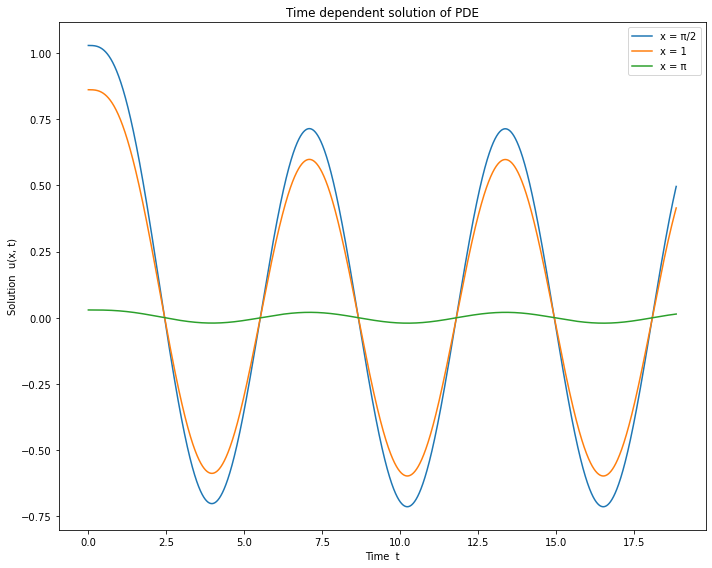

In [47]:
plt.rcParams["figure.figsize"] = (10,8)

plt.plot(t, u[idx_pi_half,:], label = "x = π/2")
plt.plot(t, u[idx_one,:], label = "x = 1")
plt.plot(t, u[idx_pi,:], label = "x = π")

plt.xlabel("Time  t")
plt.ylabel("Solution  u(x, t)")
plt.legend()
plt.title("Time dependent solution of PDE")
plt.tight_layout()


Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [48]:
def eigenvalues(A:ndarray, max_iter:int = 1000) -> ndarray:
  """
  Compute eigenvalues of given matrix A by exploiting LU factorization.
  
  Inputs:
    A: matrix for which evalues are computed.
    max_iter: maximum number of iterations required.
  """
  n = A.shape[0]
  evals = zeros(n)
  (L, U) = LU(A)
  
  for _ in range(max_iter):
    Anew = U.dot(L)
    (L, U) = LU(Anew)

  evals = sort(diag(Anew)) 
  return evals

In [49]:
def eigenvectors(A:ndarray, evals:ndarray, eps:float = 1e-5) -> ndarray:
    """
    Return the eigenvectors associated to given eigenvalues by exploiting the inverse power method with shift (mu).

    Input: 
        A: matrix which assumptions are check on the power method function.
        evals: eigenvalues array.
        eps: tolerance value.
    """
    n = A.shape[0]
    evectors = zeros_like(A)

    for idx in range(n):
        _, eve = inverse_power_method( A, evals[idx] + eps )
        evectors[:,idx] = eve

    return evectors

Compute the inverse of the matrix A exploiting the derived LU factorization

In [50]:
def compute_inverse(A:ndarray) -> ndarray:
    """
    Compute the inverse of matrix A by exploiting LU factorization.

    Inputs:
        A: squared, non-singular matrix. 
    """
    assert(shape(A)[0] == shape(A)[1]), "Matrix has to be squared"
    assert(linalg.det(A) != 0), "The matrix A has to be invertible/non-singular"
    
    A = array(A, dtype = 'float64')         # define A matrix 
    n = A.shape[0]
    
    inv_A = zeros((n, n))                   # set inverse matrix
    I = identity(n)                         # set identity matrix
    P, L, U = LU(A, pivot=True)             # do LU factorization
    
    for k in range(n):
        y = L_solve(L, matmul(I[:, k],P))   #solve linear system to find y
        inv_A[:,k] = U_solve(U, y)          #solve linear system to find the inverse
    
    return inv_A

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [51]:
def newton(f:Callable, Df:Callable, x:int, eps:float = 1e-10, max_iter:int = 1000) -> ndarray:
    """
    Implement Newton method for searching the zeros of a function f.
    Return the solution x.
               
    Inputs: 
        f: a function for which searching zeros.
        Df: derivative of f.
        x: point where to start the search.
        eps: tolerance for stopping criteria.
        max_iter = max number of iterations.
    """
    
    for _ in range(max_iter):
        x = x - f(x) / Df(x)
        if(abs(f(x)) < eps):
            return x
    return x                

In [52]:
def backward_euler(y0:int, omega:list, N:int = 100) -> Tuple[ndarray,ndarray]:
    """
    Solve ordinary differential equation using Backward Euler and Newton method.
    Returns the time discretization t and the solution y.
    
    Inputs: 
        y0: point where to start searching zeros.
        omega:  domain interval.
        N: number of nodes.
    """
    
    h = (omega[1] - omega[0])/ N                                    #define time step
    t = linspace(omega[0], omega[1], num = N+1, dtype='float64')
    y = zeros_like(t)                                               #initialize array for the solution
    y[0] = y0                                                       #first solution is y0
    
    for k in range(1, N+1):                                         #for each node
        f = lambda x : x - y[k-1] + h * t[k] * power(x, 2)          #evaluate f at tk
        Df = lambda x : 1 + 2 * h * t[k] * x                        #evaluate Df at tk
        y[k] = newton(f, Df, y[k-1])                                #find y by Newton method
        
    return t, y

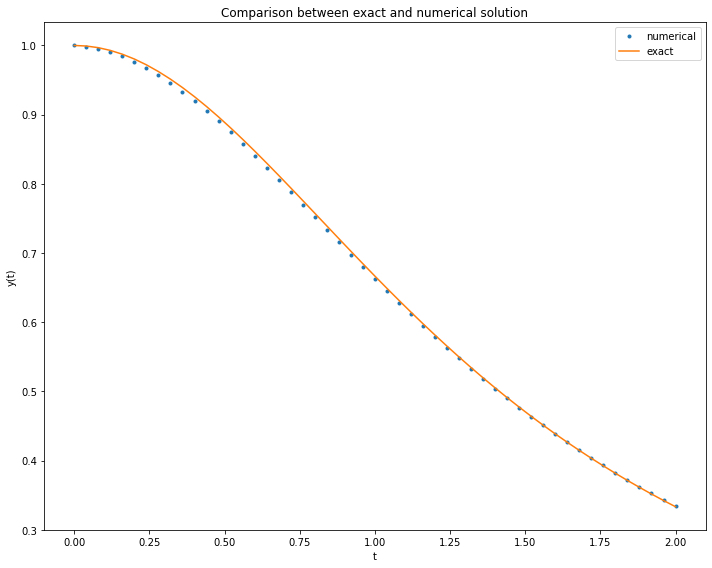

In [53]:
y0 = 1
omega = [0, 2]
t, y = backward_euler(y0, omega, N = 50)
y_exact = lambda x: 2/(power(x, 2) + 2)

plt.rcParams["figure.figsize"] = (10,8)
plt.plot(t, y, '.',  label = 'numerical')
plt.plot(t, y_exact(t), label = 'exact')
plt.legend()
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title('Comparison between exact and numerical solution')
plt.tight_layout()
plt.show()